In [2]:
%matplotlib inline

import numpy as n
import matplotlib.pyplot as p
import numpy.fft as f
import scipy.signal as sig
import copy

# Theory

In this notebook, I investigate the ues of optimal quadratic estimators on a simple band limited signal with a naive fourier transform and constant covariance. 

According to Ali 2015, we first estimate $\widehat{q}_\alpha$ as 
$$
\widehat{q}_\alpha = \frac{1}{2} x^\dagger C^{-1} Q_\alpha C^{-1} x - b_\alpha 
$$
where x is the data vector, $C$ is the covariance matrix, and $Q_\alpha$ performs the Fourier transform at the $\alpha^{th}$ k-bin. The power spectrum is determined from $\widehat{q}$ with the normalization matrix
$$
\widehat{p} = M \widehat{q}
$$
which results in $\widehat{p}$ being composed of an add-mixture of different modes
$$
\widehat{p} = W p
$$
where $W$ is the window function matrix with 
$$
W = MF
$$
where
$$
F_{\alpha \beta} = \frac{1}{2} tr\left[ C^{-1} Q_\alpha C^{-1} Q_\beta \right]
$$
If we do not weight $x$ by $C^{-1}$ but rather by an arbitrary weighting matrix which we will call $U$, we get a similar equation for $F$ with $C^{-1} \to U$. 
$$
F_{\alpha \beta} = \frac{1}{2} tr \left[ U Q_\alpha U Q_\beta \right]
$$
In this notebook, I will test the normalization matrix technique with $U$ set to the identity and employ te weights matrix described in Ali-2015 where $F$ is Cholsky-decomposed into $LL^\dagger$ with $L$ being lower triangular. Ali 2015 choose $M=D L^\dagger$ where $D$ is a diagonal matrix that ensures that the rows of $W=MF=DL^{-1}F$ sum to one. 


# Simple Case

We will consider a 20 frequency bins with 100 kHz widths between 149 and 151 MHz. The delay bins are 1/(2MHz) corresponding to $5 \times 10^{-7}$sec. I will set the middle two delay-bins to equal unity and zero outside. We see that the blackman window brings the side-lobes to a similar level as the signal. 

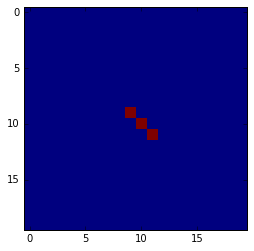

In [13]:
nf=20 #number of frequency bins
df=1e5 #width of each bin
npad=0#padding option, set to zero for now
fAxis=150e6-nf/2*df+n.arange(-nf/2,nf/2)*df #frequency axis centered at 150 MHz. 
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0])) #delay axis


deltadelay=1 #number of delay sbins from zero (plus and minus) to contaminate with foregrounds
ndelays=1+2*deltadelay #number of delays (at the center of the band) to contaminate
delays2use=delays[(nf/2-deltadelay):(nf/2+deltadelay+1)] #delays to be contaminated by foregrounds
data=n.zeros(nf,dtype=complex) #data vector (equal to foregrounds+signal)
signal=n.zeros(nf,dtype=complex)#signal vector 
foregrounds=n.zeros(nf,dtype=complex)#foregrounds vector

scaleForegrounds=100.
scaleSignal=20e-3

fAmps=n.random.normal(size=(ndelays,2),scale=scaleForegrounds)#each foreground mode is a complex exponential with period of delay
                                              #gaussian random amplitude and uniform random phase
sAmps=n.random.normal(size=(nf,2),scale=scaleSignal)     #signal amplitudes are gaussian in amplitude and uniform in phase. 

powerIndex=-0.8                               #modulate foreground amplitudes by power law index. 

#populate foregrounds
for mm,delay in enumerate(delays2use):
    foregrounds+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,0])*(fAxis/fAxis[nf/2])**powerIndex
    foregrounds+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,1])*(fAxis/fAxis[nf/2])**powerIndex


#populated signal
for mm,delay in enumerate(delays):
    signal+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,0])
    signal+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,1])


#window function
window=sig.blackmanharris(nf)
window[:]=1.

#Apply padding, update delay axis. 
window=n.pad(window,((npad,npad)),mode='constant')
data=n.pad(data,((npad,npad)),mode='constant')
foregrounds=n.pad(foregrounds,((npad,npad)),mode='constant')
signal=n.pad(signal,((npad,npad)),mode='constant')
nf=nf+2*npad
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0]))


#now generate a covariance matrix
covDelay=n.diag(2.*n.ones(nf)*scaleSignal**2.)

for mm in range(nf/2-deltadelay,nf/2+deltadelay+1):
    covDelay[mm,mm]+=2.*scaleForegrounds**2.
    
p.imshow(covDelay,interpolation='nearest')
p.show()
#windowX,windowY=n.meshgrid(sig.blackmanharris(nf),sig.blackmanharris(nf))
#covFrequency=n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay*windowX*windowY))))
covFrequency=n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay))))



fGrid,fpGrid=n.meshgrid(fAxis,fAxis)

covFrequency=scaleForegrounds**2.*2*n.sinc(2*n.pi*(fGrid-fpGrid)*delays[nf/2+deltadelay+1])#n.sin(2*n.pi*(fGrid-fpGrid)*delays[nf/2-deltadelay])/(n.pi*(fGrid-fpGrid))
covFrequency+=scaleSignal**2.*n.diag(n.ones((nf,1)))

#print n.linalg.cond(covFrequency)
U,S,V=n.linalg.svd(covFrequency.conj())
covFrequencyInv=n.einsum('ij,j,jk',V.T,1./S,U.T)



#straightforward windowed ffts of signal, data, and foregrounds for comparison
fsignal=f.fftshift(f.fft(f.fftshift(signal*window)))
fdata=f.fftshift(f.fft(f.fftshift(data*window)))
fforegrounds=f.fftshift(f.fft(f.fftshift(foregrounds*window)))


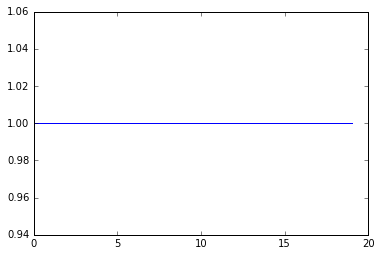

In [14]:
p.plot(window)

First we construct the $Q_\alpha$ matrices for each delay bin. We also compute unnormalized power spectra using the OQE formalism. We order data so that we have zero, than k0,-k1,k1,-k2,k2,-k3,k3 etc...

In [15]:
qMatrixFull=n.zeros((nf,nf,nf),dtype=complex) #the Qmatrix for all delay bins. the first axis is delay
                                              #ordered a-la Ali 2015 as 0,-1,1,-2,2,-3,3,... so that 
                                              #Cholskey decomposition can prevent small k -> large k 
                                              #leakage
                                              #the second and third axes are frequency and are ordered from -nf/2
                                              #to nf/2-1 with zero in the center. 
                    
fsignal_un=n.zeros(nf,dtype=complex)          #un-normalized signal (without M matrix application)
fdata_un=n.zeros(nf,dtype=complex)            #un-normalized data  (un-normalized signal+un-normalized foregrounds)
fforegrounds_un=n.zeros(nf,dtype=complex)     #un-normalized foregrounds




uMatrix=covFrequencyInv


#now generate un-normalized signal and foregrounds
for mm,delay in enumerate(delays):
    #cs=n.exp(2j*n.pi*(mm-nf/2)*n.arange(-nf/2.,nf/2.)/nf) #qmatrix is the outer product of signusoids. 
                                                            #note that the delay of the sinusoid is set by
                                                             #delaymap
    #cs*=window
    _cs=n.zeros(nf)
    _cs[mm]=1.
    cs=f.fftshift(f.ifft(f.fftshift(_cs)))*window*nf
    #qMatrix=n.outer((cs),n.conj(cs).T)                       #qmatrix is outer product of delay-transform
    qMatrix=n.einsum('i,j',cs,cs.conj())
    qMatrixFull[mm,:,:]=qMatrix                              #populate qmatrixfull row
    
    
    fsignal_un[mm]=.5*n.dot(n.conj(n.dot(uMatrix,signal)).T,n.dot(qMatrix,n.dot(uMatrix,signal)))    #q=1/2 x W Q W x (signal)
    fforegrounds_un[mm]=.5*n.dot(n.conj(n.dot(uMatrix,foregrounds)).T,n.dot(qMatrix,foregrounds)) #same for foregrounds
    fdata_un[mm]=fforegrounds_un[mm]+fsignal_un[mm]  #data un-normalized = foregrounds+signal un-normalized
    


Now Compare OQE and direct fft power spectra. They are the same. This also verifies our indexing scheme.

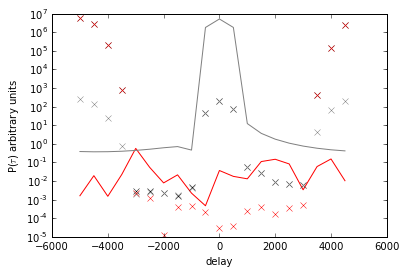

In [16]:
#plot power spectrum from windowed FT
p.plot(delays*1e9,.5*n.abs(fdata)**2.,color='k')
p.plot(delays*1e9,.5*n.abs(fsignal)**2.,color='r')
p.plot(delays*1e9,.5*n.abs(fforegrounds)**2.,color='grey')

#plot power spectrum from OQE application
p.plot(delays*1e9,(n.abs(fdata_un[:])),color='k',marker='x',ls='none')
p.plot(delays*1e9,(n.abs(fsignal_un[:])),color='r',marker='x',ls='none')
p.plot(delays*1e9,(n.abs(fforegrounds_un[:])),color='grey',marker='x',ls='none')
p.yscale('log')

p.xlabel('delay')
p.ylabel('P($\\tau$) arbitrary units')


Now let's construct the $F$ matrix and perform Cholsky Decomposition.

In [17]:

#uMatrix=n.diag(window).astype(complex) #this is the weighting matrix 
                                       #(taking the place of the inverse covariance matrix.)
                                       #I take it to be the window function. 
fMatrix=n.zeros((nf,nf),dtype=complex)
for mm in range(nf):
    for nn in range(nf):
        ftq=n.dot(uMatrix,n.dot(qMatrixFull[mm,:,:],n.dot(uMatrix,qMatrixFull[nn,:,:])))
        fMatrix[mm,nn]=.5*n.trace(ftq)


order = n.array([10,11,9,12,8,20,0,13,7,14,6,15,5,16,4,17,3,18,2,19,1]) # XXX needs generalizing
order=n.array([10,11,9,12,8,19,0,13,7,14,6,15,5,16,4,17,3,18,2,1])
print len(order)

order=n.zeros(nf)
order[0]=nf/2
order[1]=nf/2+1
order[2]=nf/2-1
order[3]=nf/2+2
order[4]=nf/2-2
order[5]=nf-1
order[6]=0

for mm in range(4,nf/2):
    order[2*mm-1]=nf/2+mm-1
    order[2*mm]=nf/2-mm+1

order[-1]=1
order=order.astype(int)
    
print order
#iorder = n.argsort(order)
#fMatrix_o = n.take(n.take(fMatrix,order, axis=0), order, axis=1)
#lMatrix_o = n.linalg.cholesky(fMatrix_o)
#U,S,V = n.linalg.svd(lMatrix_o.conj())
#mMatrix_o = n.dot(n.transpose(V), n.dot(n.diag(1./S), n.transpose(U)))      
#mMatrix = n.take(n.take(mMatrix_o,iorder, axis=0), iorder, axis=1)

#wMatrix=n.dot(mMatrix,fMatrix)
#norm  = wMatrix.sum(axis=-1); norm.shape += (1,)
#mMatrix/=norm; wMatrix=n.dot(mMatrix,fMatrix)
mMatrix=n.linalg.inv(fMatrix)


#mMatrix=n.linalg.inv(fMatrix)

fdata_n=n.dot(mMatrix,fdata_un.T)
fsignal_n=n.dot(mMatrix,fsignal_un.T)
fforegrounds_n=n.dot(mMatrix,fforegrounds_un.T)



20
[10 11  9 12  8 19  0 13  7 14  6 15  5 16  4 17  3 18  2  1]


In [18]:
print mMatrix.shape
print fforegrounds_un.shape

(20, 20)
(20,)


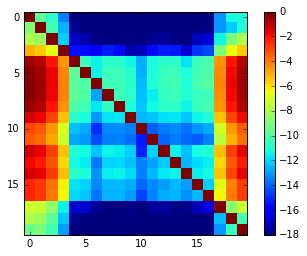

In [19]:
p.imshow(n.log10(n.abs(n.dot(mMatrix,fMatrix))),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()

Compare the normalized power spectrum $\widehat{p} = M \widehat{q}$. Things definitely don't look better...

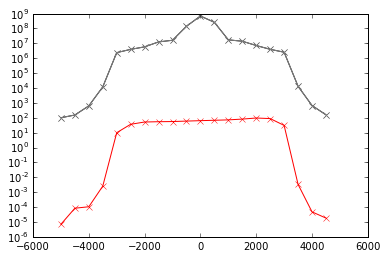

In [20]:
#p.plot(delays*1e9,n.abs(fdata_un[:]),color='k',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fsignal_un[:]),color='r',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fforegrounds_un[:]),color='grey',marker='o',ls='none')

p.plot(delays*1e9,(n.abs(fdata_n[:])),color='k',marker='x')#,ls='none')
p.plot(delays*1e9,(n.abs(fsignal_n[:])),color='r',marker='x')#,ls='none')
p.plot(delays*1e9,(n.abs(fforegrounds_n[:])),color='grey',marker='x')#,ls='none')
p.yscale('log')


Lets check on the window function which is equal to $W=MF=DL^\dagger$ and compare to the unnormalized window function. We see that the unnormalized window function is a blackman harris window while the normalized one is a blackman with the lower k values excised. This seems sensible and I'm surprised that we are seeing as much foreground leakage as we are. 

In [21]:
p.imshow(n.log10(n.abs(wMatrix)),interpolation='nearest')
p.colorbar()
p.show()

NameError: name 'wMatrix' is not defined